In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import json
from PIL import Image
import random
import matplotlib.pyplot as plt

In [2]:
# ==============================================================================
# Configuration Constants
# ==============================================================================
# --- Paths ---
# NOTE: Adjust these paths to your environment
DATASET_PATH = "../TestDataSet"  # Path to the original dataset (ImageFolder structure)
LABEL_JSON_PATH = os.path.join(DATASET_PATH, "labels_list.json") # Path to the JSON file mapping folder order to ImageNet indices
ADV_DATASET_PATH = "../Adversarial_Test_Set_3" # Output directory for PGD adversarial images

# --- Model & Device ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
WEIGHTS = 'IMAGENET1K_V1'
# --- PGD Attack Parameters ---
# Epsilon: Max L-infinity perturbation allowed (relative to [0, 1] pixel range)
EPSILON = 0.4
PATCH_SIZE = 32
# Alpha: Step size for each PGD iteration (often eps / iters or smaller)
PGD_ALPHA = 0.12 # As provided in user's code
# Iterations: Number of PGD steps
PGD_ITERS = 40    # As provided in user's code

# --- Dataloader Parameters ---
BATCH_SIZE = 32  # Adjusted for potentially faster generation/evaluation
NUM_WORKERS = 0  # Adjust based on your system


In [3]:
resnet34 = torchvision.models.resnet34(weights=WEIGHTS)
resnet34.eval().to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
MEAN_NORMS = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1).to(DEVICE)
STD_NORMS = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1).to(DEVICE)

In [5]:
normalize = transforms.Normalize(MEAN_NORMS.squeeze().tolist(), STD_NORMS.squeeze().tolist())
inv_normalize = transforms.Normalize(
    mean=(-MEAN_NORMS / STD_NORMS).squeeze().tolist(),
    std=(1.0 / STD_NORMS).squeeze().tolist()
)

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

with open(os.path.join(DATASET_PATH, "labels_list.json"), "r") as f:
    label_lines = json.load(f)
true_imagenet_indices = [int(line.split(":")[0]) for line in label_lines]

In [7]:
imagefolder = torchvision.datasets.ImageFolder(root=DATASET_PATH, transform=transform)
folder_to_imagenet_index = {
    class_name: true_imagenet_indices[i]
    for i, class_name in enumerate(imagefolder.classes)
}
imagefolder.samples = [
    (path, folder_to_imagenet_index[os.path.basename(os.path.dirname(path))])
    for path, _ in imagefolder.samples
]

In [8]:
dataloader = DataLoader(imagefolder, batch_size=1, shuffle=False)

In [9]:
os.makedirs(ADV_DATASET_PATH, exist_ok=True)

In [10]:
def patch_pgd_attack(image, label, epsilon=EPSILON, patch_size=PATCH_SIZE, alpha=PGD_ALPHA, steps=PGD_ITERS):
    image = image.clone().detach().to(DEVICE)
    orig = image.clone().detach()
    _, _, H, W = image.shape

    # 🎯 Centered patch
    x = (W - patch_size) // 2
    y = (H - patch_size) // 2

    perturbed = image.clone().detach().requires_grad_(True)

    for _ in range(steps):
        output = resnet34(perturbed)
        loss = torch.nn.functional.cross_entropy(output, label)
        resnet34.zero_grad()
        loss.backward()

        grad = perturbed.grad.data
        patch = grad[:, :, y:y+patch_size, x:x+patch_size].sign()

        perturbed = perturbed.clone()
        perturbed[:, :, y:y+patch_size, x:x+patch_size] = (
            perturbed[:, :, y:y+patch_size, x:x+patch_size] + alpha * patch
        )

        perturbed = torch.max(torch.min(perturbed, orig + epsilon), orig - epsilon)
        perturbed = torch.clamp(perturbed, 0, 1).detach().requires_grad_(True)

    return perturbed.detach()

In [11]:
# Generate and save
adv_images = []
true_labels = []
pred_changed = []

for idx, (img, label) in enumerate(tqdm(dataloader, desc="Patch Attack")):
    img, label = img.to(DEVICE), label.to(DEVICE)

    # Original prediction
    with torch.no_grad():
        orig_pred = resnet34(img).argmax(dim=1).item()

    # Patch adversarial image
    adv_img = patch_pgd_attack(img.clone(), label, epsilon=0.5, patch_size=32, alpha=0.1, steps=20)

    with torch.no_grad():
        adv_pred = resnet34(adv_img).argmax(dim=1).item()

    # Save
    adv_images.append(adv_img.squeeze().cpu())
    true_labels.append(label.item())
    pred_changed.append(orig_pred != adv_pred)

    out_path = os.path.join(ADV_DATASET_PATH, f"{idx:04d}.png")
    torchvision.utils.save_image(inv_normalize(adv_img.squeeze().cpu()).clamp(0, 1), out_path)

Patch Attack: 100%|██████████| 500/500 [03:51<00:00,  2.16it/s]



Patch Attack Visualizations:


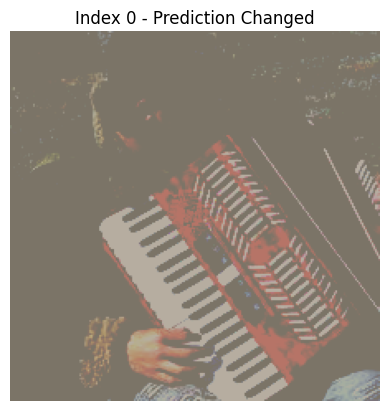

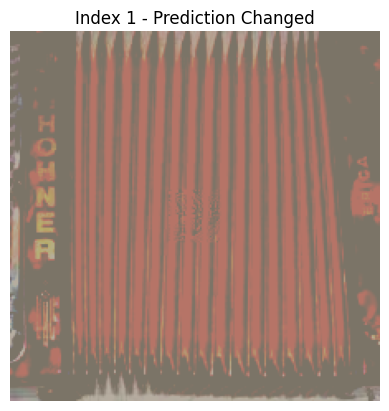

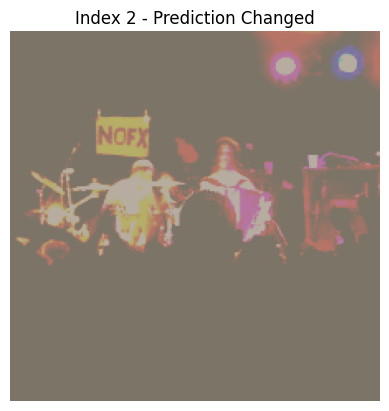

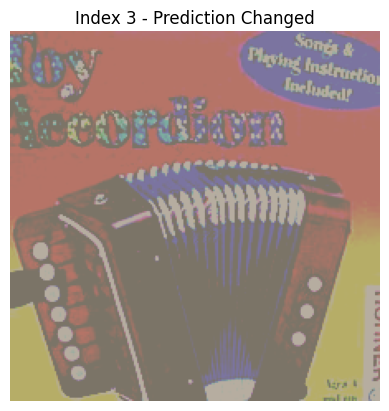

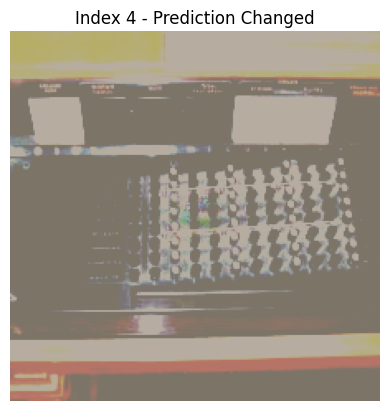

In [12]:
# Visualize 3–5 changed predictions
print("\nPatch Attack Visualizations:")
count = 0
for i in range(len(adv_images)):
    if pred_changed[i]:
        plt.imshow(inv_normalize(adv_images[i]).permute(1, 2, 0).clamp(0, 1))
        plt.title(f"Index {i} - Prediction Changed")
        plt.axis("off")
        plt.show()
        count += 1
    if count == 5:
        break

In [13]:
# Evaluation
class AdvDataset(torch.utils.data.Dataset):
    def __init__(self, image_tensors, labels):
        self.images = image_tensors
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

adv_dataset = AdvDataset(adv_images, true_labels)
adv_loader = DataLoader(adv_dataset, batch_size=32)

In [14]:
def evaluate(model, dataloader):
    top1_correct = 0
    top5_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, top1 = outputs.topk(1, dim=1)
            _, top5 = outputs.topk(5, dim=1)
            top1_correct += (top1.squeeze() == labels).sum().item()
            top5_correct += sum([labels[i] in top5[i] for i in range(labels.size(0))])
            total += labels.size(0)
    return 100 * top1_correct / total, 100 * top5_correct / total

top1_adv, top5_adv = evaluate(resnet34, adv_loader)
print(f"\nPatch Attack Top-1 Accuracy: {top1_adv:.2f}%")
print(f"Patch Attack Top-5 Accuracy: {top5_adv:.2f}%")


Patch Attack Top-1 Accuracy: 11.00%
Patch Attack Top-5 Accuracy: 31.80%
